# Preprocess 

## Download Dataset

In [26]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [32]:
import os
dir_path = "./data"
os.makedirs(dir_path, exist_ok=True)
!kaggle datasets download -d mczielinski/bitcoin-historical-data -p data/ --unzip
!rm -rvf data/data/

Dataset URL: https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data
License(s): CC-BY-SA-4.0
... resuming from 69188160 bytes (48616472 bytes left) ...
100%|███████████████████████████████████████▊| 112M/112M [00:10<00:00, 6.53MB/s]
100%|████████████████████████████████████████| 112M/112M [00:10<00:00, 4.76MB/s]


## Params

In [37]:
EPOCHS = 30
BATCH_SIZE = 64
VAL_SIZE = 1000
LOOKBACK_STEPS = 10
SHIFTING_LOOKBACK_STEPS = 1
SHIFTING_TARGET_STEPS= 10
TIME_INTERVAL = 30

## import

In [38]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
import mlflow
import mlflow.tensorflow
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense,LSTM,Dropout # type: ignore
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.callbacks import ModelCheckpoint # type: ignore
import json
import keras_tuner
import keras_tuner as kt
from keras_tuner import Hyperband
from keras_tuner import RandomSearch
plt.style.use('fivethirtyeight')
import os

## Reading csv

In [39]:
df = pd.read_csv('data/btcusd_1-min_data.csv')
df 

,Timestamp,Open,High,Low,Close,Volume,datetime
0,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01 10:01:00+00:00
1,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01 10:02:00+00:00
2,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01 10:03:00+00:00
3,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01 10:04:00+00:00
4,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01 10:05:00+00:00
...,...,...,...,...,...,...,...
6944795,1.742169e+09,82554.00,82554.00,82554.00,82554.00,0.072000,NaN
6944796,1.742169e+09,82584.00,82615.00,82584.00,82615.00,0.194670,NaN
6944797,1.742169e+09,82555.00,82555.00,82555.00,82555.00,0.002680,NaN
6944798,1.742170e+09,82555.00,82555.00,82555.00,82555.00,0.000000,NaN


## Handling Null Values

In [40]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df.set_index('Timestamp', inplace=True)
df1 = df.interpolate()
df1 = df1.iloc[::TIME_INTERVAL]
df = df1
df

/tmp/ipykernel_4800/2345634559.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df1 = df.interpolate()


,Open,High,Low,Close,Volume,datetime
Timestamp,,,,,,
2012-01-01 10:01:00,4.58,4.58,4.58,4.58,0.000000,2012-01-01 10:01:00+00:00
2012-01-01 10:31:00,4.58,4.58,4.58,4.58,0.000000,2012-01-01 10:31:00+00:00
2012-01-01 11:01:00,4.58,4.58,4.58,4.58,0.000000,2012-01-01 11:01:00+00:00
2012-01-01 11:31:00,4.58,4.58,4.58,4.58,0.000000,2012-01-01 11:31:00+00:00
2012-01-01 12:01:00,4.58,4.58,4.58,4.58,0.000000,2012-01-01 12:01:00+00:00
...,...,...,...,...,...,...
2025-03-16 21:51:00,82724.00,82732.00,82724.00,82732.00,0.030646,NaN
2025-03-16 22:21:00,82428.00,82454.00,82339.00,82339.00,1.369150,NaN
2025-03-16 22:51:00,82279.00,82289.00,82279.00,82279.00,1.062527,NaN


## Ploting Close Price

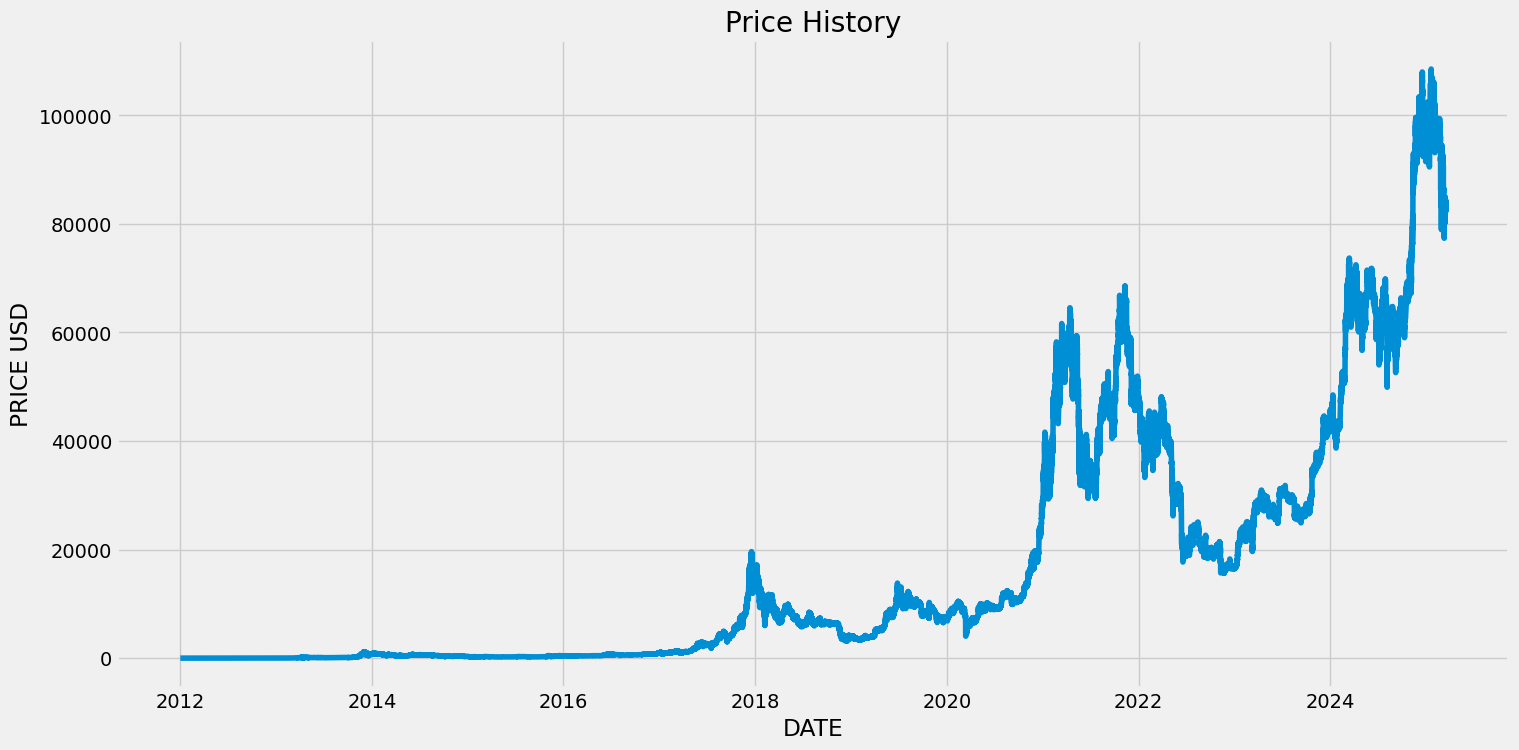

In [41]:
plt.figure(figsize=(16,8))
plt.title('Price History')
plt.plot(df['Close'])
plt.xlabel('DATE')
plt.ylabel('PRICE USD')
plt.show()

## Scaling Spliting 

In [42]:
# Define features and target
target_col = 'Close'
features = ['Close' ]

def create_sequences(data, target_col, lookback_steps, shifting_lookback_steps, shifting_target_steps=0):
    X, y = [], []
    for i in range(0, math.ceil((len(data) - lookback_steps)/shifting_lookback_steps)-shifting_target_steps):
        X.append(data.iloc[i*shifting_lookback_steps:(shifting_lookback_steps*i) + lookback_steps][features].values)
        y.append(data.iloc[(i*shifting_lookback_steps)+lookback_steps+shifting_target_steps][target_col])
    return np.array(X), np.array(y)


# Create sequences first
X, y = create_sequences(df, target_col, lookback_steps=LOOKBACK_STEPS, shifting_lookback_steps=SHIFTING_LOOKBACK_STEPS, shifting_target_steps=SHIFTING_TARGET_STEPS)  # Adjust time steps as needed

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = X[:-VAL_SIZE], X[-VAL_SIZE:], y[:-VAL_SIZE], y[-VAL_SIZE:]

# Initialize scalers for X (features) and y (target)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

# Transform the validation data
X_val_scaled = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))

# Block Diagram of Custom LSTM Layer

## CustomLSTMCell 

1. **Input Concatenation**:
    - Concatenate the input \( x_t \) and the hidden state \( h_t \).
    - Concatenate the input \( x_t \) and the feature state \( fe_t \).
    - Concatenate the input \( x_t \) and the cell state \( c_t \).

2. **Forget Gate \( f_t \)**:
    - Calculate \( f_t \) using the concatenated input and hidden state.
    - \( f_t = \text{sigmoid}(W_f \cdot [x_t, h_t] + b_f) \)

3. **Input Gate \( i_t \)**:
    - Calculate \( i_t \) using the concatenated input and hidden state.
    - \( i_t = \text{sigmoid}(W_i \cdot [x_t, h_t] + b_i) \)

4. **Cell Candidate \( \hat{c}_t \)**:
    - Calculate \( \hat{c}_t \) using the concatenated input and hidden state.
    - \( \hat{c}_t = \text{tanh}(W_c \cdot [x_t, h_t] + b_c) \)

5. **Output Gate \( o_t \)**:
    - Calculate \( o_t \) using the concatenated input and hidden state.
    - \( o_t = \text{sigmoid}(W_o \cdot [x_t, h_t] + b_o) \)

6. **Cell State Update**:
    - Update the cell state \( c_t \) using the forget gate and input gate.
    - \( c_t = f_t \cdot c_t + i_t \cdot \hat{c}_t \)

7. **Hidden State Update**:
    - Update the hidden state \( h_t \) using the output gate.
    - \( h_t = o_t \cdot \text{tanh}(c_t) \)

8. **Feature State Updates**:
    - Compute intermediate feature states \( \hat{fe}_t \) and \( fe_h \).
    - Calculate \( B \) using the concatenated input and cell state.
    - Compute additional feature states \( fe_1 \) and \( fe_2 \).
    - Calculate the final feature state \( fe_t \) using \( fe_1 \), \( fe_2 \), and a recurrent feature \( fe_f \).

## CustomLSTM

1. **Initialize States**:
    - Initialize \( h_t \), \( c_t \), and \( fe_t \) to zeros.

2. **Sequence Processing**:
    - Transpose the input sequence for time-step-wise processing.
    - Iterate over each time step:
        - Update \( h_t \), \( c_t \), and \( fe_t \) using the `CustomLSTMCell`.

3. **Output Handling**:
    - If `return_sequences` is True, return the sequence of hidden states.
    - If `return_state` is True, return the final states \( h_t \) and \( c_t \).

## Block Diagram Illustration

```plaintext
                            CustomLSTM Layer
  ┌─────────────────────────────────────────────────────┐
  │                                                     │
  │  Initialize h_t, c_t, fe_t to zeros                 │
  │                                                     │
  │  Inputs (batch_size, seq_length, input_dim)         │
  │     │                                               │
  │     │                                               │
  │     ▼                                               │
  │  Transpose Inputs (seq_length, batch_size, input_dim)│
  │     │                                               │
  │     │                                               │
  │     ▼                                               │
  │  For each time step:                                │
  │     │                                               │
  │     ├──────────────┬───────────────┬───────────────┤
  │     │              │               │               │
  │     ▼              ▼               ▼               ▼
  │  ┌──────────────────────────────────────────────┐  │
  │  │                CustomLSTMCell                │  │
  │  │                                              │  │
  │  │  Concatenate x_t and h_t, fe_t, c_t          │  │
  │  │                                              │  │
  │  │  Forget Gate: f_t                            │  │
  │  │  Input Gate: i_t                             │  │
  │  │  Cell Candidate: c_hat_t                     │  │
  │  │  Output Gate: o_t                            │  │
  │  │                                              │  │
  │  │  Update c_t and h_t                          │  │
  │  │                                              │  │
  │  │  Feature State Updates: fe_t                 │  │
  │  └──────────────────────────────────────────────┘  │
  │     │                                               │
  │     │                                               │
  │     ▼                                               │
  │  Collect Outputs                                    │
  │                                                     │
  │  Final Outputs:                                     │
  │  - Sequence of h_t if return_sequences=True         │
  │  - Final states if return_state=True                │
  │                                                     │
  └─────────────────────────────────────────────────────┘


## ReLSTM CELL

In [43]:

class CustomLSTMCell(tf.keras.layers.Layer):
    def __init__(self, units, activation='tanh', recurrent_activation='sigmoid', use_bias=True, recurrent_dropout=0.0, **kwargs):
        super(CustomLSTMCell, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.recurrent_activation = tf.keras.activations.get(recurrent_activation)
        self.use_bias = use_bias
        self.recurrent_dropout = recurrent_dropout

    def build(self, input_shape):
        self.input_dim = input_shape[-1] # features number
        
        self.W_f = self.add_weight(shape=(self.input_dim + self.units, self.units), initializer='random_normal', name='W_f')
        self.b_f = self.add_weight(shape=(self.units,), initializer='zeros', name='b_f') if self.use_bias else None
        
        self.W_i = self.add_weight(shape=(self.input_dim + self.units, self.units), initializer='random_normal', name='W_i')
        self.b_i = self.add_weight(shape=(self.units,), initializer='zeros', name='b_i') if self.use_bias else None
        
        self.W_c = self.add_weight(shape=(self.input_dim + self.units, self.units), initializer='random_normal', name='W_c')
        self.b_c = self.add_weight(shape=(self.units,), initializer='zeros', name='b_c') if self.use_bias else None
        
        self.W_o = self.add_weight(shape=(self.input_dim + self.units, self.units), initializer='random_normal', name='W_o')
        self.b_o = self.add_weight(shape=(self.units,), initializer='zeros', name='b_o') if self.use_bias else None

        self.W_s = self.add_weight(shape=(self.input_dim + self.units, self.units), initializer='random_normal', name='W_s')
        self.b_s = self.add_weight(shape=(self.units,), initializer='zeros', name='b_s') if self.use_bias else None

        self.W_ff = self.add_weight(shape=(self.units, self.units), initializer='random_normal', name='W_ff')
        self.b_ff = self.add_weight(shape=(self.units,), initializer='zeros', name='b_ff') if self.use_bias else None
        
        self.W_fe = self.add_weight(shape=(self.units, self.units), initializer='random_normal', name='W_fe')
        self.b_fe = self.add_weight(shape=(self.units,), initializer='zeros', name='b_fe') if self.use_bias else None
        
        self.W_z = self.add_weight(shape=(self.units, self.units), initializer='random_normal', name='W_z')
        self.b_z = self.add_weight(shape=(self.units,), initializer='zeros', name='b_z') if self.use_bias else None
        
        self.W_B = self.add_weight(shape=(self.input_dim + self.units, self.units), initializer='random_normal', name='W_B')
        self.b_B = self.add_weight(shape=(self.units,), initializer='zeros', name='b_B') if self.use_bias else None
        
        

    def call(self, inputs, states, training=None):
        h_t, c_t, fe_t = states
        if 0 < self.recurrent_dropout < 1 and training:
            h_t = tf.nn.dropout(h_t, rate=self.recurrent_dropout)

        concat_h_t = tf.concat([inputs, h_t], axis=-1)
        concat_fe_t = tf.concat([inputs, fe_t], axis=-1)
        concat_c_t = tf.concat([inputs, c_t], axis=-1)
        fe_hat = tf.matmul(concat_fe_t,self.W_s) + (self.b_s if self.use_bias else 0)
        fe_h= fe_hat + tf.matmul(concat_h_t,(1-self.W_s))+ (self.b_s if self.use_bias else 0)
        

        B_hat= tf.matmul(concat_c_t, self.W_B) + (self.b_B if self.use_bias else 0)
        f_t = self.recurrent_activation(tf.matmul(concat_h_t, self.W_f) + (self.b_f if self.use_bias else 0))
        i_t = self.recurrent_activation(tf.matmul(concat_h_t, self.W_i) + (self.b_i if self.use_bias else 0))
        c_hat_t = self.activation(tf.matmul(concat_h_t, self.W_c) + (self.b_c if self.use_bias else 0))
        o_t = self.recurrent_activation(tf.matmul(concat_h_t, self.W_o) + (self.b_o if self.use_bias else 0))
  
        fe_1 = self.recurrent_activation(tf.matmul(B_hat,self.W_z) + (self.b_z if self.use_bias else 0))
        fe_2 = self.activation(tf.matmul(B_hat,self.W_fe) + (self.b_fe if self.use_bias else 0))


        fe_f = tf.matmul(f_t, self.W_ff) + (self.b_ff if self.use_bias else 0)

        c_t_next = f_t * c_t + i_t * c_hat_t
        h_t_next = o_t * self.activation(c_t_next)
        fe_1_2=fe_1 * fe_2
        fe_ff = fe_t * fe_f
        fe_t_next=fe_1_2+fe_ff
        
        return h_t_next, [h_t_next, c_t_next, fe_t_next]
    

    def get_config(self):
        config = super(CustomLSTMCell, self).get_config()
        config.update({
            'units': self.units,
            'activation': tf.keras.activations.serialize(self.activation),
            'recurrent_activation': tf.keras.activations.serialize(self.recurrent_activation),
            'use_bias': self.use_bias,
            'recurrent_dropout': self.recurrent_dropout,
        })
        return config


class CustomLSTM(tf.keras.layers.Layer):
    def __init__(self, units, activation='tanh', recurrent_activation='sigmoid', use_bias=True, return_sequences=False, return_state=False, recurrent_dropout=0.0, unroll=False, **kwargs):
        super(CustomLSTM, self).__init__(**kwargs)
        self.units = units
        self.return_sequences = return_sequences
        self.return_state = return_state
        self.unroll = unroll
        self.cell = CustomLSTMCell(units, activation=activation, recurrent_activation=recurrent_activation, use_bias=use_bias, recurrent_dropout=recurrent_dropout)
        
    def call(self, inputs, training=None):
        batch_size = tf.shape(inputs)[0]
        seq_length = tf.shape(inputs)[1]
        
        h_t = tf.zeros((batch_size, self.units))
        c_t = tf.zeros((batch_size, self.units))
        fe_t = tf.zeros((batch_size, self.units))
        
        states = [h_t, c_t, fe_t]
        
        inputs_transposed = tf.transpose(inputs, [1, 0, 2])
        
        def step(prev_states, x_t):
            
            h_t, c_t, fe_t = prev_states
            
            h_t, [h_t, c_t, fe_t] = self.cell(x_t, [h_t, c_t, fe_t], training=training)
            
            return [h_t, c_t, fe_t]

        if self.unroll:
            # Unroll the loop manually if unroll=True
            outputs = []
            for i in range(seq_length):
                states = step(states, inputs_transposed[i])
                outputs.append(states[0])
            outputs = tf.stack(outputs, axis=0)
            
        else:
            states = tf.scan(step, inputs_transposed, initializer=states, parallel_iterations=1)
            outputs = states[0]
            
        
        outputs = tf.transpose(outputs, [1, 0, 2])
        
        final_states = [states[0][-1], states[1][-1]]
        
        if self.return_sequences:
            if self.return_state:
                return outputs, final_states
            return outputs
        
        if self.return_state:
            return outputs[:, -1, :], final_states
        return outputs[:, -1, :]
    
    def get_config(self):
        config = super(CustomLSTM, self).get_config()
        config.update({
            'units': self.units,
            'activation': tf.keras.activations.serialize(self.cell.activation),
            'recurrent_activation': tf.keras.activations.serialize(self.cell.recurrent_activation),
            'use_bias': self.cell.use_bias,
            'return_sequences': self.return_sequences,
            'return_state': self.return_state,
            'recurrent_dropout': self.cell.recurrent_dropout,
            'unroll': self.unroll,
        })
        return config


# Training

## ReLSTM Training

In [50]:
inputs = tf.keras.Input(shape=(X_train_scaled.shape[1],X_train_scaled.shape[2]))
x = CustomLSTM(16, return_sequences=True)(inputs)
#x = Dropout(0.2)(x)
#x = Dense(16)(x)
x = CustomLSTM(24, return_sequences=True)(x)
#x = Dropout(0.2)(x)
x = CustomLSTM(24)(x)
#x = Dropout(0.2)(x)
x = Dense(1)(x)

model_Relstm = tf.keras.Model(inputs, x)
model_Relstm.summary()
model_Relstm.compile(optimizer='adam', loss='mse', metrics=['mae','mape','mse','msle','cosine_similarity'])

history_Relstm=model_Relstm.fit(X_train_scaled,
                                  y_train_scaled,batch_size=BATCH_SIZE,
                                  epochs=EPOCHS,
                                  validation_data=(X_val_scaled,y_val_scaled))

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_lstm_12 (CustomLSTM)     │ (None, 10, 16)         │         2,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_lstm_13 (CustomLSTM)     │ (None, 10, 24)         │         7,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_lstm_14 (CustomLSTM)     │ (None, 24)             │         8,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,129 (74.72 KB)

 Trainable params: 19,129 (74.72 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 47s 12ms/step - cosine_similarity: 0.9353 - loss: 0.0034 - mae: 0.0161 - mape: 5983.3101 - mse: 0.0034 - msle: 0.0021 - val_cosine_similarity: 1.0000 - val_loss: 4.5980e-04 - val_mae: 0.0165 - val_mape: 2.0844 - val_mse: 4.5980e-04 - val_msle: 1.4154e-04
Epoch 2/30
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - cosine_similarity: 0.8499 - loss: 2.9799e-05 - mae: 0.0033 - mape: 950.0182 - mse: 2.9799e-05 - msle: 1.4783e-05 - val_cosine_similarity: 1.0000 - val_loss: 3.3750e-04 - val_mae: 0.0131 - val_mape: 1.6603 - val_mse: 3.3750e-04 - val_msle: 1.0433e-04
Epoch 3/30
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - cosine_similarity: 0.8587 - loss: 2.7478e-05 - mae: 0.0031 - mape: 820.8250 - mse: 2.7478e-05 - msle: 1.3521e-05 - val_cosine_similarity: 1.0000 - val_loss: 9.1432e-04 - val_mae: 0.0263 - val_mape: 3.3221 - val_mse: 9.1432e-04 - val_msle: 2.7881e-04
Epoch 4/30
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - cosine_similarity: 0.8637 - l

## LSTM Training

In [51]:
inputs = tf.keras.Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]))
x = tf.keras.layers.LSTM(32, return_sequences=True)(inputs)
#x = tf.keras.layers.Dropout(0.2)(x)
#x = Dense(16)(x)
x = tf.keras.layers.LSTM(32, return_sequences=True)(x)
#x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.LSTM(32)(x)
#x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1)(x)

model_lstm = tf.keras.Model(inputs, x)
model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape', 'mse', 'msle', 'cosine_similarity'])
model_lstm.summary()

history_lstm = model_lstm.fit(
        X_train_scaled, y_train_scaled, 
        batch_size=BATCH_SIZE, 
        epochs=EPOCHS, 
        validation_data=(X_val_scaled, y_val_scaled))

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 10, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 10, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,025 (82.13 KB)

 Trainable params: 21,025 (82.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - cosine_similarity: 0.9386 - loss: 7.6491e-04 - mae: 0.0075 - mape: 2847.3723 - mse: 7.6491e-04 - msle: 4.7727e-04 - val_cosine_similarity: 1.0000 - val_loss: 3.6106e-04 - val_mae: 0.0136 - val_mape: 1.7229 - val_mse: 3.6106e-04 - val_msle: 1.1158e-04
Epoch 2/30
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - cosine_similarity: 0.8625 - loss: 2.9301e-05 - mae: 0.0031 - mape: 836.5793 - mse: 2.9301e-05 - msle: 1.4358e-05 - val_cosine_similarity: 1.0000 - val_loss: 4.1781e-04 - val_mae: 0.0157 - val_mape: 1.9717 - val_mse: 4.1781e-04 - val_msle: 1.3016e-04
Epoch 3/30
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - cosine_similarity: 0.8673 - loss: 2.8931e-05 - mae: 0.0031 - mape: 824.2108 - mse: 2.8931e-05 - msle: 1.4063e-05 - val_cosine_similarity: 1.0000 - val_loss: 4.9639e-04 - val_mae: 0.0175 - val_mape: 2.2053 - val_mse: 4.9639e-04 - val_msle: 1.5541e-04
Epoch 4/30
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 45s 12ms/step - cosine_similarity

# Validation

## Valiation of the ReLSTM and LSTM models

In [52]:
# Ensure the input shape for X_val_scaled is (num_samples, time_steps, num_features)
# If X_val_scaled has the correct shape, you can proceed with prediction
Relstm_y_pred_val_scaled = model_Relstm.predict(X_val_scaled)
lstm_y_pred_val_scaled = model_lstm.predict(X_val_scaled)  

# Inverse transform the predicted and actual values
Relstm_y_pred_val_original = scaler_y.inverse_transform(Relstm_y_pred_val_scaled).flatten()
lstm_y_pred_val_original = scaler_y.inverse_transform(lstm_y_pred_val_scaled).flatten()

y_val_original = y_val  # If you haven't scaled y_val, keep it as is

# Calculate evaluation metrics
print("Evaluation for FLSTM::::::::::::::::::::::::::::::::")
mse = mean_squared_error(y_val_original, Relstm_y_pred_val_original)
mae = mean_absolute_error(y_val_original, Relstm_y_pred_val_original)
rmse = tf.sqrt(mse).numpy()
# Print the evaluation results
print(f"Mean Squared Error (MSE) on Validation Set for ReLSTM is : {mse}")
print(f"Mean Absolute Error (MAE) on Validation Set for ReLSTM : {mae}")
print(f"Root Mean Squared Error (RMSE) on Validation Set for ReLSTM : {rmse}")
print("Evaluation for LSTM::::::::::::::::::::::::::::::::")
mse = mean_squared_error(y_val_original, lstm_y_pred_val_original)
mae = mean_absolute_error(y_val_original, lstm_y_pred_val_original)
rmse = tf.sqrt(mse).numpy()
# Print the evaluation results
print(f"Mean Squared Error (MSE) on Validation Set for LSTM is : {mse}")
print(f"Mean Absolute Error (MAE) on Validation Set for LSTM is : {mae}")
print(f"Root Mean Squared Error (RMSE) on Validation Set for LSTM is : {rmse}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Evaluation for FLSTM::::::::::::::::::::::::::::::::
Mean Squared Error (MSE) on Validation Set for ReLSTM is : 2942666.0769610596
Mean Absolute Error (MAE) on Validation Set for ReLSTM : 1198.5360625
Root Mean Squared Error (RMSE) on Validation Set for ReLSTM : 1715.4200876056743
Evaluation for LSTM::::::::::::::::::::::::::::::::
Mean Squared Error (MSE) on Validation Set for LSTM is : 3936663.9566195067
Mean Absolute Error (MAE) on Validation Set for LSTM is : 1514.38390625
Root Mean Squared Error (RMSE) on Validation Set for LSTM is : 1984.1028089843294


## Ploting Predicted for ReLSTM and LSTM and Actual

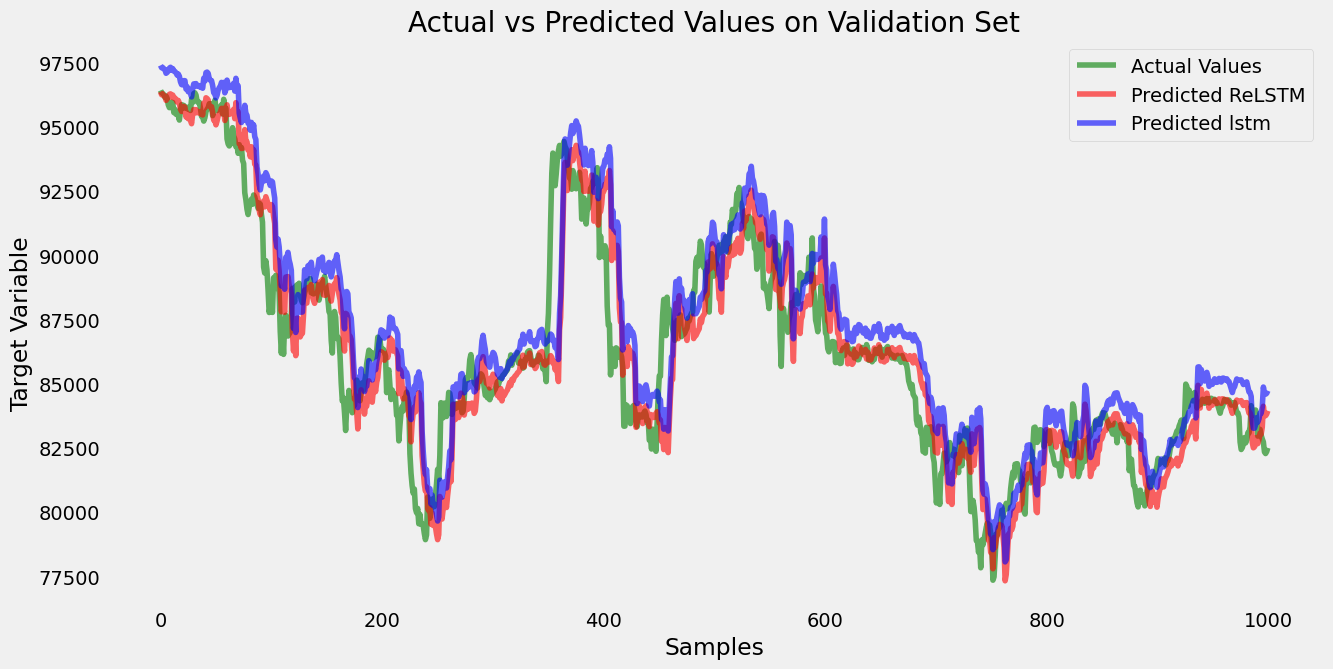

In [53]:
# Plotting the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_val_original, label='Actual Values', color='green', alpha=0.6)
plt.plot(Relstm_y_pred_val_original, label='Predicted ReLSTM', color='red', alpha=0.6)
plt.plot(lstm_y_pred_val_original, label='Predicted lstm', color='blue', alpha=0.6)

plt.title('Actual vs Predicted Values on Validation Set')
plt.xlabel('Samples')
plt.ylabel('Target Variable')
plt.legend()
plt.grid()

plt.savefig("predictions_plot.png", dpi=300, bbox_inches='tight')

plt.show()